# Modeling Preliminary BPA Product Block with Shaping Capacity

*Draft work discussion purposes only, no guarentees, etc.*   

This notebook presents an open source optimization model for shaping the BPA Block with Shaping Capacity (BWSC) product.  

This model is built on Linopy, which depends on Xarray.  

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import linopy as lp
import xarray as xr

# Make a Dummy Load Dataset for Experimenting

In [21]:
def generate_hourly_loads(start_date='2024-01-01', end_date='2024-01-31', amplitude=100, daily_variation=20):
    """
    Function to generate hourly loads to work with the toy model.  
    """
    datetime_index = pd.date_range(start=start_date, end=pd.to_datetime(end_date) + pd.Timedelta(days=1), freq='H')[:-1]
    hours_in_day = 24
    base_sine_wave = amplitude * (np.sin(2 * np.pi * datetime_index.hour / hours_in_day) + 1)
    daily_variation_wave = daily_variation * (np.sin(2 * np.pi * datetime_index.dayofyear / 30) + 1)
    loads = base_sine_wave + daily_variation_wave + 100
    load_df = pd.DataFrame(data={'load_mw': loads}, index=datetime_index)
    load_df.index.name = 'datetime'
    return load_df

,load_mw
datetime,
2024-01-01 00:00:00,224.158234
2024-01-01 01:00:00,250.040138
2024-01-01 02:00:00,274.158234
2024-01-01 03:00:00,294.868912
2024-01-01 04:00:00,310.760774
...,...
2024-01-31 19:00:00,127.565651
2024-01-31 20:00:00,137.555693
2024-01-31 21:00:00,153.447556


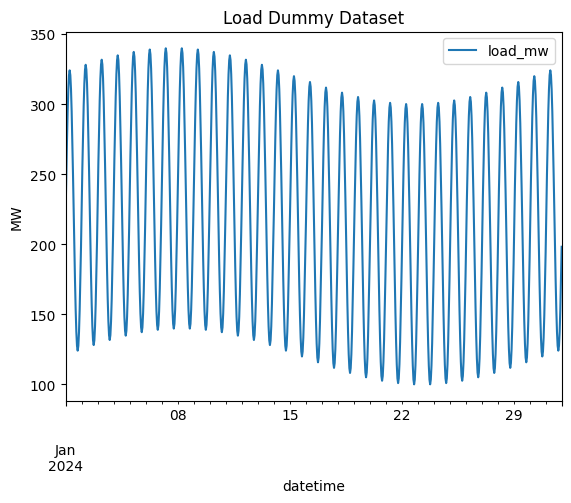

In [22]:
load_df = generate_hourly_loads()
load_df.plot()
plt.title('Load Dummy Dataset')
plt.ylabel('MW')
load_df

Since linopy is built on xarray, we want to put our data into an xarray DataArray.  Since we named the index "datetime" xarray will be able to infer the dimension and the coordinates from the pandas Series.  

In [23]:
load_xr = xr.DataArray(load_df['load_mw'])
load_xr

<xarray.DataArray 'load_mw' (datetime: 744)> Size: 6kB
array([224.15823382, 250.04013833, 274.15823382, 294.86891194,
       310.76077419, 320.75081645, 324.15823382, 320.75081645,
       310.76077419, 294.86891194, 274.15823382, 250.04013833,
       224.15823382, 198.27632931, 174.15823382, 153.4475557 ,
       137.55569344, 127.56565119, 124.15823382, 127.56565119,
       137.55569344, 153.4475557 , 174.15823382, 198.27632931,
       228.13473286, 254.01663737, 278.13473286, 298.84541098,
       314.73727324, 324.72731549, 328.13473286, 324.72731549,
       314.73727324, 298.84541098, 278.13473286, 254.01663737,
       228.13473286, 202.25282835, 178.13473286, 157.42405474,
       141.53219248, 131.54215023, 128.13473286, 131.54215023,
       141.53219248, 157.42405474, 178.13473286, 202.25282835,
       231.75570505, 257.63760956, 281.75570505, 302.46638316,
       318.35824542, 328.34828767, 331.75570505, 328.34828767,
       318.35824542, 302.46638316, 281.75570505, 257.63760956,
       231.75570505, 205.87380054, 181.75570505, 161.04502693,
       145.15316467, 135.16312242, 131.75570505, 135.16312242,
       145.15316467, 161.04502693, 181.75570505, 205.87380054,
       234.86289651, 260.74480102, 284.86289651, 305.57357463,
       321.46543689, 331.45547914, 334.86289651, 331.45547914,
...
       125.26272676, 115.27268451, 111.86526714, 115.27268451,
       125.26272676, 141.15458902, 161.86526714, 185.98336263,
       215.84176618, 241.72367069, 265.84176618, 286.5524443 ,
       302.44430656, 312.43434881, 315.84176618, 312.43434881,
       302.44430656, 286.5524443 , 265.84176618, 241.72367069,
       215.84176618, 189.95986167, 165.84176618, 145.13108806,
       129.23922581, 119.24918355, 115.84176618, 119.24918355,
       129.23922581, 145.13108806, 165.84176618, 189.95986167,
       220.        , 245.88190451, 270.        , 290.71067812,
       306.60254038, 316.59258263, 320.        , 316.59258263,
       306.60254038, 290.71067812, 270.        , 245.88190451,
       220.        , 194.11809549, 170.        , 149.28932188,
       133.39745962, 123.40741737, 120.        , 123.40741737,
       133.39745962, 149.28932188, 170.        , 194.11809549,
       224.15823382, 250.04013833, 274.15823382, 294.86891194,
       310.76077419, 320.75081645, 324.15823382, 320.75081645,
       310.76077419, 294.86891194, 274.15823382, 250.04013833,
       224.15823382, 198.27632931, 174.15823382, 153.4475557 ,
       137.55569344, 127.56565119, 124.15823382, 127.56565119,
       137.55569344, 153.4475557 , 174.15823382, 198.27632931])
Coordinates:
  * datetime  (datetime) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:00:00

# Shaped Block Optimization Model

## Model Parameters
The BPA block product as a flat monthly average energy with shaping up to +/- `max_shaping`, where `max_shaping` is a fraction of the average energy.  Additionally, there is a ramping constraint we will call `max_ramping` which is the maximum different in energy from one hour to the next.  `max_ramping` is a fraction of `max_shaping`.  Finally, there is a constraint on the amount of total shaping that can be used half way through the month, however, for this purpose, we will be making the shape energy net-neutral in both the first and the second half of the month.  Although this is more restrictive than the shaped block product, this additional constraint is thought to offset the perfect foresight assumed by the optimizer.  

We put the product variables in a dictionary for use in the model.  

In [26]:
bwsc_params = {'max_ramping': 0.1, 'max_shaping': 0.1}

## Model

The model is designed to run in a single month.  It will follow the shaping and ramping constraints at each timestep and be net neutral across the first and second halves of the month.  We assume we want more capacity during the highest load hours in the month which we achieve by maximizing `load * shape`.  

In [29]:
# Initialize the model
m = lp.Model()

# Linopy wants us to be clear about the dims, coords, and indices in the model
datetime_idx = load_xr.get_index('datetime')
dims =  ['datetime']
coords = {'datetime': datetime_idx}

# The variable shaping_factor is a vector that will vary around 1 +/- max_shaping
shaping_factor = m.add_variables(lower = 1 - bwsc_params['max_shaping'], 
                                 upper = 1 + bwsc_params['max_shaping'],
                                 dims=dims, 
                                 coords=coords, 
                                 name='shaping_factor')

# Constraints
## Ramping - Starting with the second timestep, calculate the different between each timestep
## and make sure we are within the ramping constraint
m.add_constraints(shaping_factor.sel(datetime=datetime_idx[1:]) - shaping_factor.shift(datetime=1) <= 
                  bwsc_params['max_shaping'] * bwsc_params['max_ramping'], 
                  name= 'max_ramp')
m.add_constraints(shaping_factor.sel(datetime=datetime_idx[1:]) - shaping_factor.shift(datetime=1) >= 
                  - bwsc_params['max_shaping'] * bwsc_params['max_ramping'], 
                  name='min_ramp')

## Net neutrality
### Averge shaping == 1
m.add_constraints(shaping_factor.sum() == len(datetime_idx), name='net_neutral')

### Average shaping in the first fifteen days == 1
first_fifteen_mask = datetime_idx.day <= 15
m.add_constraints(shaping_factor.where(first_fifteen_mask).sum() == first_fifteen_mask.sum(),
                  name='first_15_days_neutral')

# Objective - maximize load * shape
m.add_objective(shaping_factor * load_xr, sense='max')
m

Linopy LP model

Variables:
----------
 * shaping_factor (datetime)

Constraints:
------------
 * max_ramp (datetime)
 * min_ramp (datetime)
 * net_neutral
 * first_15_days_neutral

Status:
-------
initialized

# Solve and Interpret the Results

In [31]:
m.solve()

('ok', 'optimal')

The results come out as and xarray DataArray, which we can convert to pandas for plotting.  

Text(0, 0.5, 'MW')

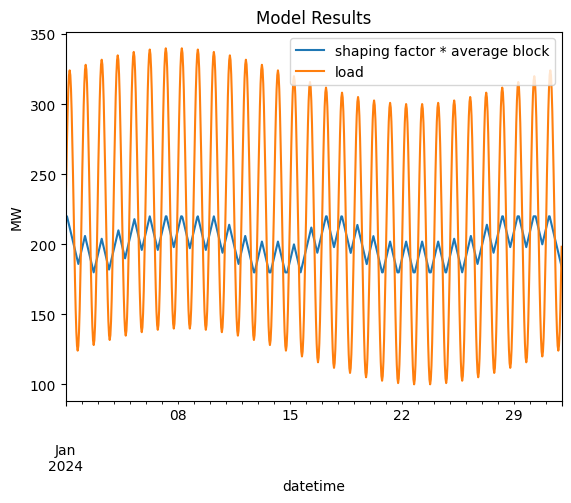

In [38]:
average_block = 200
sol = m.solution
(sol.shaping_factor.to_pandas()*average_block).plot(label='shaping factor * average block')
load_xr.to_pandas().plot(label='load')
plt.legend()
plt.title('Model Results')
plt.ylabel('MW')